In [1]:
pip install numpy

     |████████████████████████████████| 20.1 MB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

     |████████████████████████████████| 10.1 MB 3.2 MB/s eta 0:00:01    |███████████████████████▌        | 7.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 19.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

     |████████████████████████████████| 13.1 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 8.8 MB/s  eta 0:00:01
     |████████████████████████████████| 90 kB 13.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

     |████████████████████████████████| 215 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 64.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install keras

     |████████████████████████████████| 377 kB 3.4 MB/s eta 0:00:01     |████████████████████████████▋   | 337 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 268 kB 47.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 36.5 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 826 kB/s  eta 0:00:01
     |████████████████████████████████| 50 kB 7.9 MB/s  eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.3-cp37-cp37m-linux_x86_64.whl size=393338 sha256=53e9ee890389cd0d50d9b855466f4614c498522ace0abd3b0a1439d5ddf51478
  Stored in directory: /home/jovyan/.cache/pip/wheels/8a/55/a4/c0a81d27c33462cfdcb904db018f5550197e88b2b6b85beed2
Successfully built pyyaml
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install sklearn

     |████████████████████████████████| 7.0 MB 3.4 MB/s eta 0:00:01     |█████▎                          | 1.2 MB 3.4 MB/s eta 0:00:02
     |████████████████████████████████| 294 kB 36.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=1787187108a87b2234e0c7030c60952c6bd97f1d1ae235e3381c55d3cd94673c
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

     |██████████████████▋             | 245.5 MB 56.7 MB/s eta 0:00:04     |████████████████▋               | 219.5 MB 43.1 MB/s eta 0:00:05Successfully installed absl-py-0.9.0 astor-0.8.1 cachetools-4.0.0 gast-0.2.2 google-auth-1.11.2 google-auth-oauthlib-0.4.1 google-pasta-0.1.8 grpcio-1.27.2 markdown-3.2.1 opt-einsum-3.1.0 protobuf-3.11.3 pyasn1-0.4.8 pyasn1-modules-0.2.8 requests-oauthlib-1.3.0 rsa-4.0 tensorboard-2.1.0 tensorflow-2.1.0 tensorflow-estimator-2.1.0 termcolor-1.1.0 werkzeug-1.0.0 wrapt-1.12.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib notebook

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
# date parser
parser = lambda date: pd.to_datetime(date, format='%d-%m-%y %H:%M')

# load the dataset
dataframe = pd.read_csv(
    'EVANS-EFCO_final_clean_with_2018.csv', parse_dates=[0],
    index_col=[0], date_parser=parser, engine='python'
)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset[0:17543])) # dataset[0:17543] - from 2016-01-01 00:00:00 to 2017-12-31 23:00:00
train, test = dataset[0:train_size,:], dataset[train_size+1:len(dataset),:]  # whole of 2018
print(len(train), len(test))

17543 8760


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
trainY.shape, trainX.shape, testY.shape, testX.shape

((17541,), (17541, 1, 1), (8758,), (8758, 1, 1))

In [10]:
# load model
model = load_model('power-load-stacked-lstm-model.h5')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.07 RMSE


In [13]:
def mean_average_error(actual, predicted):
    mae_score = (actual - predicted).sum() / len(actual)
    print('Prediction Mean Average Error (MAE) Score: {0:.2f}'.format(mae_score))

In [14]:
def root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual_data, predicted_data))
    print('Prediction Root Mean Square Error (RMSE) Score: {0:.2f}%'.format(rmse_score))

In [15]:
actual_data = scaler.inverse_transform(dataset[:len(testPredict)])
predicted_data = scaler.inverse_transform(testPredict)

In [16]:
# RMSE score for prediction
root_mean_square_error(actual_data, predicted_data)

Prediction Root Mean Square Error (RMSE) Score: 49.92%


In [17]:
# MAE
mean_average_error(actual_data, predicted_data)

Prediction Mean Average Error (MAE) Score: 4.63


In [18]:
%matplotlib notebook

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict

In [67]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()

In [20]:
def normalize_predicted_dataset(payload, dataframe):
    date_index = dataframe.index
    predicted = pd.DataFrame(scaler.inverse_transform(payload))
    predicted = predicted.replace(np.nan, 0.0)
    predicted['Date'] = date_index
    predicted = predicted.set_index('Date')
    predicted.columns = ['Energy Consumption']
    return predicted[:-1]

In [21]:
predicted_data = normalize_predicted_dataset(testPredictPlot, dataframe)

In [22]:
def plot_monthly(test_data, prediction):
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June','July',
        'August', 'September', 'October', 'November', 'December'
    ]
    month_index = [
        '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
        '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'
    ]
    month = int(input('Enter month: e.g 1 \n'))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots()
    axis.plot(test_data[month_index[month-1]], label='Actual Consumption')
    axis.plot(prediction[month_index[month-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Datetime", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title("Energy Consumption, " + month_names[month-1] +",2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


In [23]:
def plot_seasonal(test_data, prediction):
    season_names = [
        'Long Rainy Season', 'Short Dry Season',
        'Short Rainy Season', 'First Half Of Long Dry Season',
        'Second Half Of Long Dry Season'
    ]
    season_index = [
        '2018-03:2018-07', '2018-08', '2018-09:2018-10-21',
        '2018-01:2018-02', '2018-10-22:2018-12'
    ]
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots()
    if ':' in season_index[season-1]:
        index_list = season_index[season-1].split(':')
        axis.plot(test_data[index_list[0]:index_list[1]], label='Actual Consumption')
        axis.plot(prediction[index_list[0]:index_list[1]], label='Predicted Consumption', c='orange')
    else:
        axis.plot(test_data[season_index[season-1]], label='Actual Consumption')
        axis.plot(prediction[season_index[season-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Datetime", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title(season_names[season-1] +",2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


Enter month: e.g 1 
1


<IPython.core.display.Javascript object>


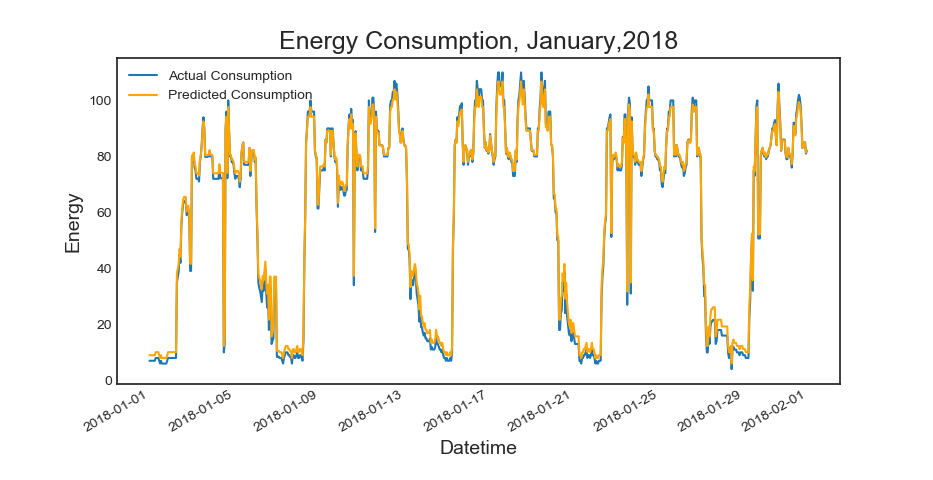

In [127]:
# plot_monthly(dataframe[:'2018-09-24'], predicted_data)
plot_monthly(dataframe, predicted_data)


        1. Long Rainy Season 	 2. Short Dry Season
        3. Short Rainy Season 	 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    4


<IPython.core.display.Javascript object>


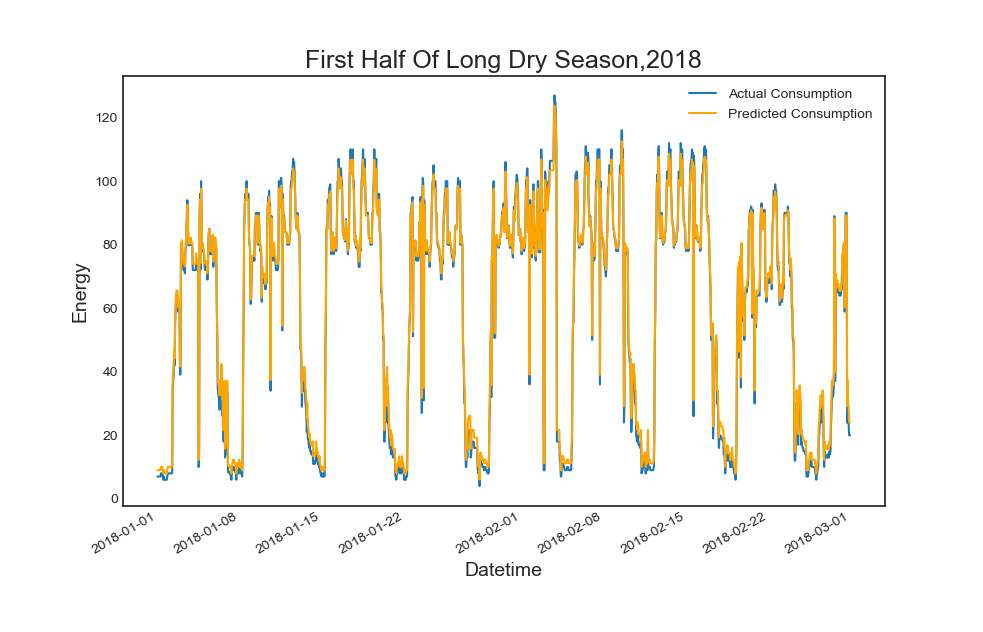

In [126]:
# plot_seasonal(dataframe[:'2018-09-24'], predicted_data)
plot_seasonal(dataframe, predicted_data)

In [40]:
def plot_monthly_density(test_data, prediction):
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June','July',
        'August', 'September', 'October', 'November', 'December'
    ]
    month_index = [
        '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
        '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'
    ]
    month = int(input('Enter month: e.g 1 \n'))
    
    test_plot_data = test_data[month_index[month-1]].reset_index()
    prediction_plot_data = prediction[month_index[month-1]].reset_index()

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    fig = sns.kdeplot(
        test_plot_data['ENERGY CONSUMPTION'].values,
        bw=.2, color="blue",shade=True, label='Actual Consumption'
    )
    fig = sns.kdeplot(
        prediction_plot_data['Energy Consumption'].values,
        bw=.2, color="orange", shade=True, label='Predicted Consumption'
    )
    plt.xlabel('')
    plt.ylabel('Energy', fontsize=14)
    plt.title("Energy Consumption, " + month_names[month-1] +",2018", fontsize=18)
    plt.yticks(fig.get_yticks(), fig.get_yticks() * 6000)
    plt.xticks([])
    return plt.show()

Enter month: e.g 1 
12


<IPython.core.display.Javascript object>


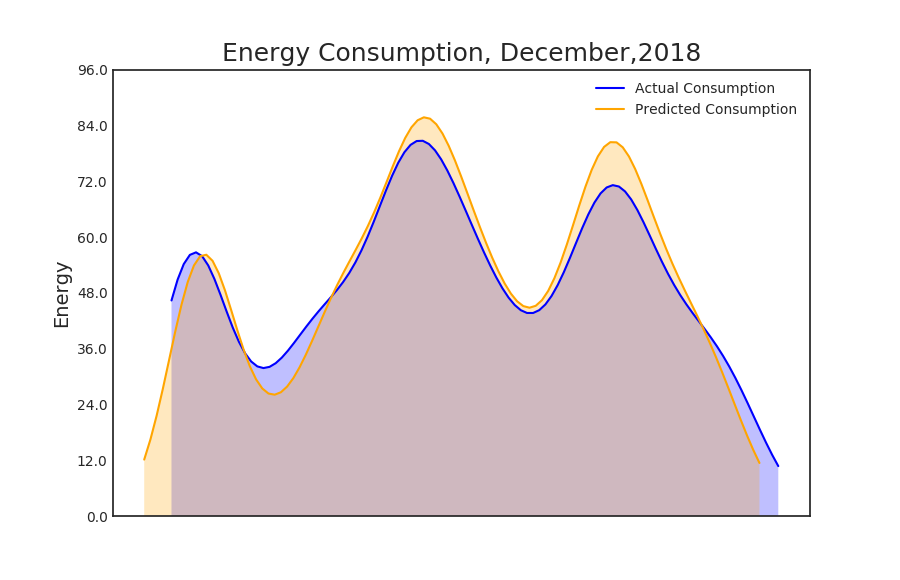

In [52]:
plot_monthly_density(dataframe, predicted_data)

In [54]:
def plot_seasonal_density(test_data, prediction):
    season_names = [
        'Long Rainy Season', 'Short Dry Season',
        'Short Rainy Season', 'First Half Of Long Dry Season',
        'Second Half Of Long Dry Season'
    ]
    season_index = [
        '2018-03:2018-07', '2018-08', '2018-09:2018-10-21',
        '2018-01:2018-02', '2018-10-22:2018-12'
    ]
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in season_index[season-1]:
        index_list = season_index[season-1].split(':')
        test_plot_data = test_data[index_list[0]:index_list[1]].reset_index()
        prediction_plot_data = prediction[index_list[0]:index_list[1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=.2, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=.2, color="orange", shade=True, label='Predicted Consumption'
        )
    else:
        test_plot_data = test_data[season_index[season-1]].reset_index()
        prediction_plot_data = prediction[season_index[season-1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=.2, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=.2, color="orange", shade=True, label='Predicted Consumption'
        )
    plt.xlabel('')
    plt.ylabel("Energy", fontsize=14)
    plt.title(season_names[season-1] +",2018", fontsize=18)
    plt.legend()
    plt.yticks(fig.get_yticks(), fig.get_yticks() * 6000)
    plt.xticks([])
    return plt.show()



        1. Long Rainy Season 	 2. Short Dry Season
        3. Short Rainy Season 	 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    5


<IPython.core.display.Javascript object>


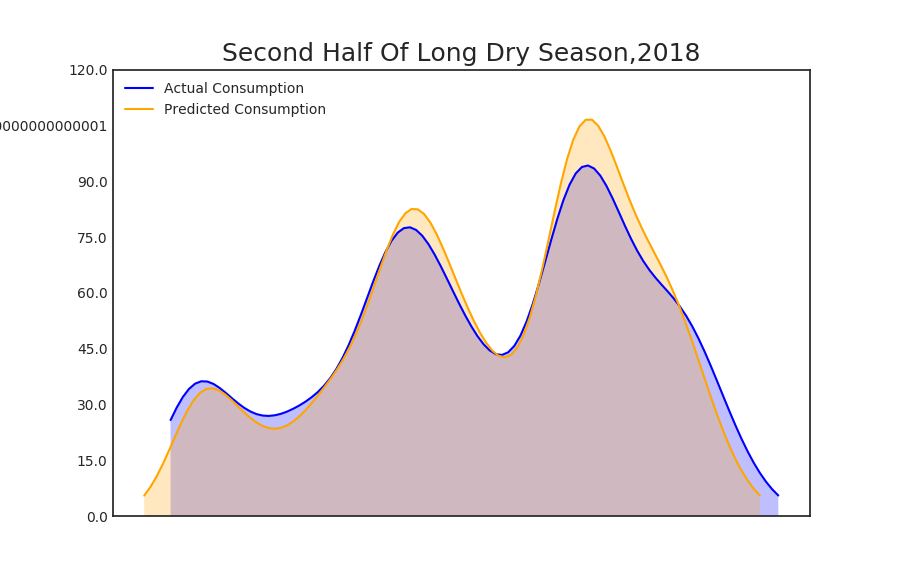

In [59]:
plot_seasonal_density(dataframe, predicted_data)